In [75]:
import pandas as pd
import numpy as np 

from gensim import corpora
from gensim.models import LsiModel, CoherenceModel
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from gensim.matutils import corpus2dense, corpus2csc, Sparse2Corpus

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

import pyLDAvis
import pyLDAvis.lda_model

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

import joblib

import warnings
warnings.filterwarnings('ignore')


In [212]:
data = pd.read_csv("data/preprocessed.csv")
data_spotify = pd.read_csv("data/preprocessed_spotify.csv")

## Latent Dirichlet Allocation

In [96]:
# Define helper function to print and return top words
def get_topic_words(lda_model, feature_names, n_words=10, print_words= False):
    topic_words = {}
    for topic_idx, topic in enumerate(lda_model.components_):
        # words = [feature_names[i] for i in topic.argsort()[:-n_words - 1:-1]]
        # topic_words[f"Topic {topic_idx}"] = words

         # Get words and their weights
        word_weights = {feature_names[i]: topic[i] for i in range(len(feature_names))}
        # Sort words by their weights in descending order
        sorted_words = dict(sorted(word_weights.items(), key=lambda item: item[1], reverse=True))
        # topic_words[f"Topic {topic_idx}"] = sorted_words
        topic_words[topic_idx] = sorted_words

        # print if needed
        if print_words:
            message = "Topic # {}: ".format(topic_idx)
            message += " ;".join([feature_names[i] for i in topic.argsort()[:-n_words - 1 :-1]])
            print(message)

    return topic_words

# Define a function to compute coherence score using gensim
def compute_coherence_score(lda_model, corpus, dictionary, feature_names):
    topics = []
    for topic_id in range(lda_model.n_components):
        topic_words = [feature_names[i] for i in np.argsort(lda_model.components_[topic_id])[::-1]]
        topics.append(topic_words)
    
    coherence_model = CoherenceModel(topics=topics, texts=corpus, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    return coherence_score

In [6]:
tfidf = TfidfVectorizer(min_df= 0.01, max_df= 0.6, ngram_range= (1,4))
X = tfidf.fit_transform(data_spotify['clean_lyrics'])
feature_names = tfidf.get_feature_names_out()

# Create a dictionary and a corpus
corpus = [text.split() for text in data_spotify['clean_lyrics']]
dictionary = Dictionary(corpus)

In [58]:
coherences = []
perplexities = []

from tqdm import tqdm
for nn in tqdm(range(2,22,2)):
    lda = LatentDirichletAllocation(n_components= nn, random_state= 0)
    lda.fit_transform(X)
    perplexities.append(lda.perplexity(X))
    coherences.append(compute_coherence_score(lda, corpus, dictionary, feature_names))
    

100%|██████████| 10/10 [1:03:44<00:00, 382.49s/it]


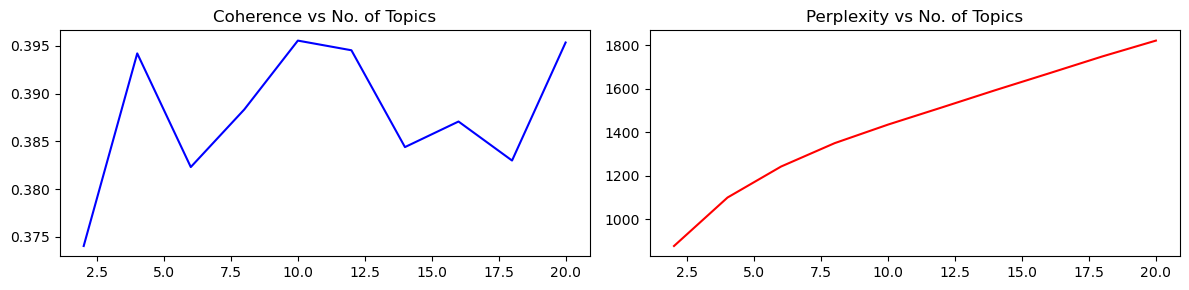

In [59]:
fig,axs = plt.subplots(figsize= (12,3), ncols= 2)
axs[0].plot(range(2,22,2), coherences, color= "blue")
axs[0].set_title("Coherence vs No. of Topics", fontsize= 12)

axs[1].plot(range(2,22,2), perplexities, color= "red")
axs[1].set_title("Perplexity vs No. of Topics", fontsize= 12)

plt.tight_layout();
fig.savefig("images/perplexity_coherence.png")

Topic # 0: wind ;sky ;fly ;light ;like ;love ;see ;away ;sun ;sea
Topic # 1: dance ;rock ;music ;roll ;come ;get ;let ;got ;party ;everybody
Topic # 2: hey ;hey hey ;whoa ;mama ;alright ;babe ;come home ;daddy ;baby ;honey
Topic # 3: fire ;im ;blood ;life ;burn ;hell ;die ;death ;dead ;one
Topic # 4: back ;home ;long ;im ;road ;come ;go ;train ;time ;goin
Topic # 5: christmas ;love ;dream ;blue ;day ;come ;moon ;star ;snow ;bell
Topic # 6: wa ;said ;one ;night ;love ;like ;saw ;came ;could ;never
Topic # 7: ive ;got ;ive got ;im ;know ;seen ;love ;aint ;time ;mr
Topic # 8: im ;nigga ;got ;like ;get ;ya ;aint ;shit ;bitch ;fuck
Topic # 9: wan ;wan na ;na ;let ;let go ;go ;baby ;know ;na go ;love
Topic # 10: im ;cant ;like ;feel ;time ;go ;know ;see ;feel like ;love
Topic # 11: want ;got ;ta ;got ta ;get ;know ;good ;girl ;im ;baby
Topic # 12: know ;im ;say ;want ;think ;way ;love ;thing ;one ;life
Topic # 13: man ;got ;wa ;like ;im ;boy ;old ;well ;little ;one
Topic # 14: love ;day ;awa

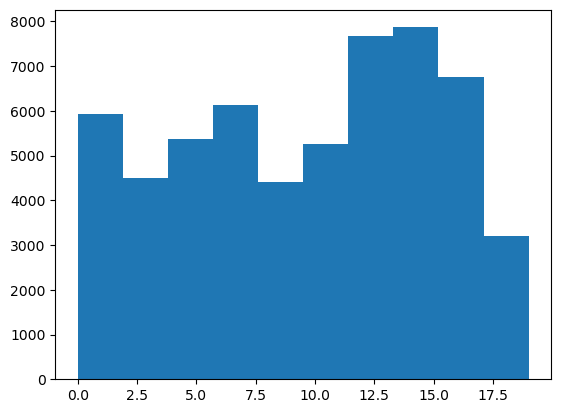

In [202]:
lda = LatentDirichletAllocation(n_components= 20, random_state= 22, max_iter= 20)
doc_topic = lda.fit_transform(X)


plt.hist(np.argmax(doc_topic, axis= 1)); 
topic_words = get_topic_words(lda, feature_names, n_words= 10, print_words= True);
topic_words = get_topic_words(lda, feature_names, print_words= False);

In [226]:
# label topics. hard code for now.
topic_name_map = {0: "fly_away", 1: "dance_rockn_roll", 2: "hey_mama", 3: "darkness_fire_death",
                  4: "going_home", 5: "christmas", 6: "time", 7: "having_feelings",
                  8: "generic_hip_hop", 9: "want_to_let_go", 10: "confusion", 11: "wanting",
                  12: "knowing", 13: "age", 14: "dreams", 15: "love",
                  16: "biblical", 17: "heartbreak", 18: "im_gonna", 19: "summer_song"}

# print most common n-grams for each topic to get the topic name
lda_topic = pd.DataFrame(doc_topic).idxmax(axis= 1)

tfidf_ngram = TfidfVectorizer(ngram_range= (2,5), min_df= 0.0005, max_df= 0.4)
dt_ngram = tfidf_ngram.fit_transform(data_spotify['clean_lyrics'])
ngram_names = tfidf_ngram.get_feature_names_out()

for tt in range(0, lda.n_components):
    print_str = "Topic " + str(tt) + ": "
    print_str = print_str + "; ".join(pd.DataFrame(tfidf_ngram.transform(data_spotify.loc[lda_topic == tt, 'clean_lyrics']).
              mean(axis=0).A1, index= ngram_names, columns= [tt]).sort_values(tt, ascending= False).head(10).index.tolist()) 
    print(print_str)

Topic 0: fly away; wind blow; far away; fly fly; gon na; let go; set free; take hand; sail away; one day
Topic 1: rock roll; gon na; come come; dance dance; wan na; rock rock; let go; come come come; shake shake; got ta
Topic 2: hey hey; hey hey hey; hey hey hey hey; come home; whoa whoa; hey hey hey hey hey; talkin bout; whoa whoa whoa; honey honey; half much
Topic 3: gon na; let go; wan na; burn burn; ha come; fire fire; got ta; die die; deep inside; higher higher
Topic 4: come back; long long; back home; long time; gon na; get back; im goin; im going; go back; long way
Topic 5: come true; merry christmas; dream come; dream come true; christmas time; christmas day; christmas tree; jingle bell; new year; time year
Topic 6: last night; thought wa; one day; first time; could see; gon na; one night; love wa; knew wa; said wa
Topic 7: ive got; ive seen; weve got; aint got; ive never; im feeling; know ive; gon na; im tired; well im
Topic 8: wan na; got ta; gon na; cause im; aint got; know 

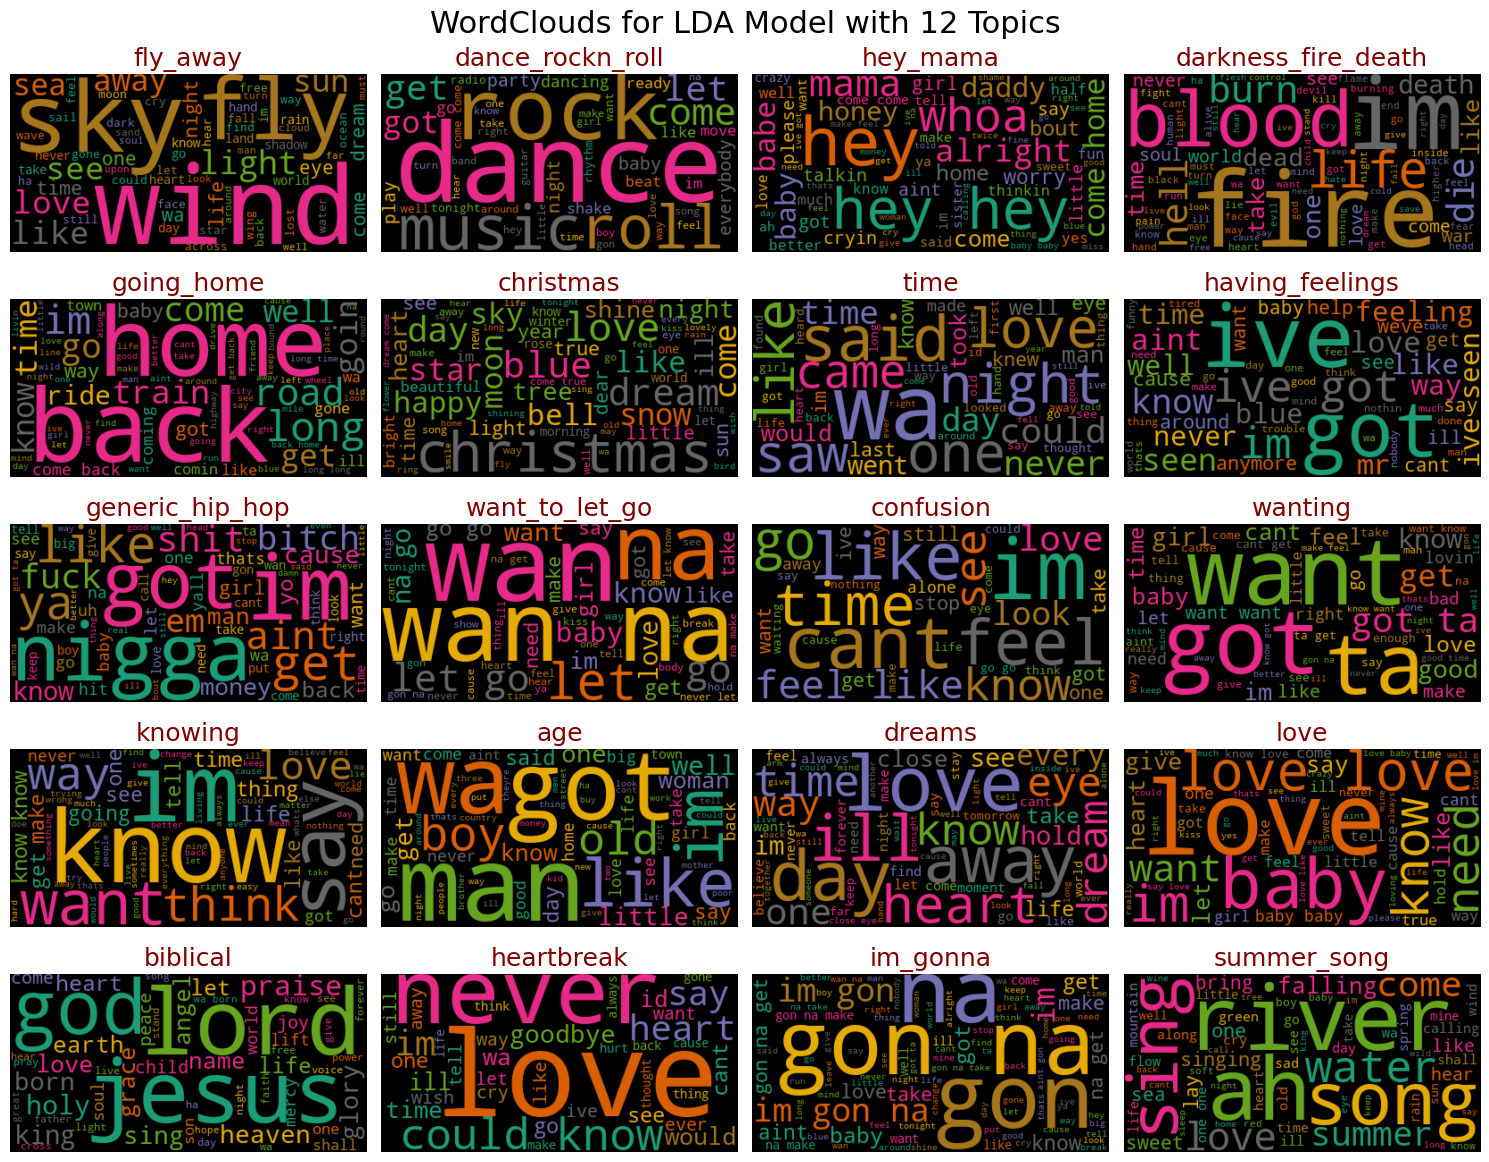

In [227]:
fig,axs = plt.subplots(figsize= (15,12), ncols= 4, nrows= int(np.ceil(lda.n_components/4)) )


def plot_wordcloud(words, title, ax):
    wordcloud = WordCloud(background_color='black', contour_color='steelblue', contour_width=1,
                          colormap='Dark2_r', min_font_size= 10).generate_from_frequencies(words)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(title, fontsize= 18, color= "maroon")
    ax.axis('off')

ii = 0; jj = 0
# Turn off the axis for each subplot
for ax in axs.flatten():
    ax.axis('off')

for topic, words in topic_words.items():
    plot_wordcloud(words, topic_name_map[topic], axs[ii][jj])
    # plot_wordcloud(words, "Topic "+str(topic), axs[ii][jj])
    if jj == 3:
        jj = 0
        ii += 1
    else:
        jj += 1

plt.suptitle("WordClouds for LDA Model with 12 Topics", fontsize= 22)
plt.tight_layout();
fig.savefig("images/lda_wordclous_16_topics.png")


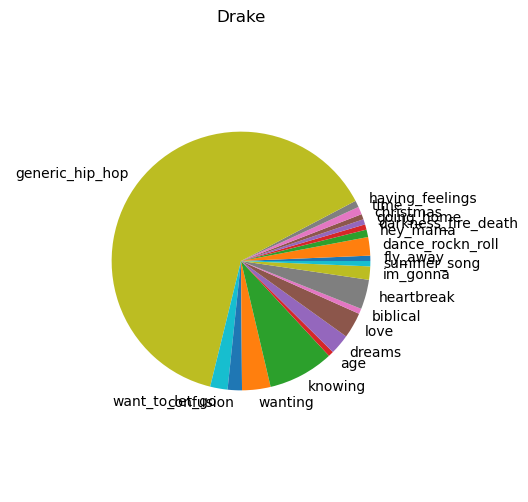

In [278]:
artist = "Drake"

test_dt = data_spotify.query(f"artist=='{artist}'")
results_dt = pd.DataFrame(lda.transform(tfidf.transform(test_dt['clean_lyrics'])), index= test_dt['song'])
results_dt.rename(columns= topic_name_map, inplace= True)

plt.figure(figsize= (6,6))
plt.pie(results_dt.sum(), labels= results_dt.columns, radius= 0.7);
plt.title(artist);

In [233]:
topic_list= [v for k,v in topic_name_map.items()]

results_dt = pd.DataFrame(lda.transform(tfidf.transform(data['clean_lyrics'])), index= data.index)
results_dt.rename(columns= topic_name_map, inplace= True)

results_dt = data[["Artist", "Year", "Song Title"]].merge(results_dt, left_index= True, right_index= True).dropna()
results_dt.to_csv("results/Billboard_songs_labeled.csv", index= None)


In [231]:
joblib.dump(lda, 'lda_model.pkl')
joblib.dump(tfidf, 'tfidf.pkl')

# # Prepare LDAvis visualization
# lda_vis = pyLDAvis.lda_model.prepare(lda, X, tfidf)
# pyLDAvis.show(lda_vis, local= False)

['tfidf.pkl']

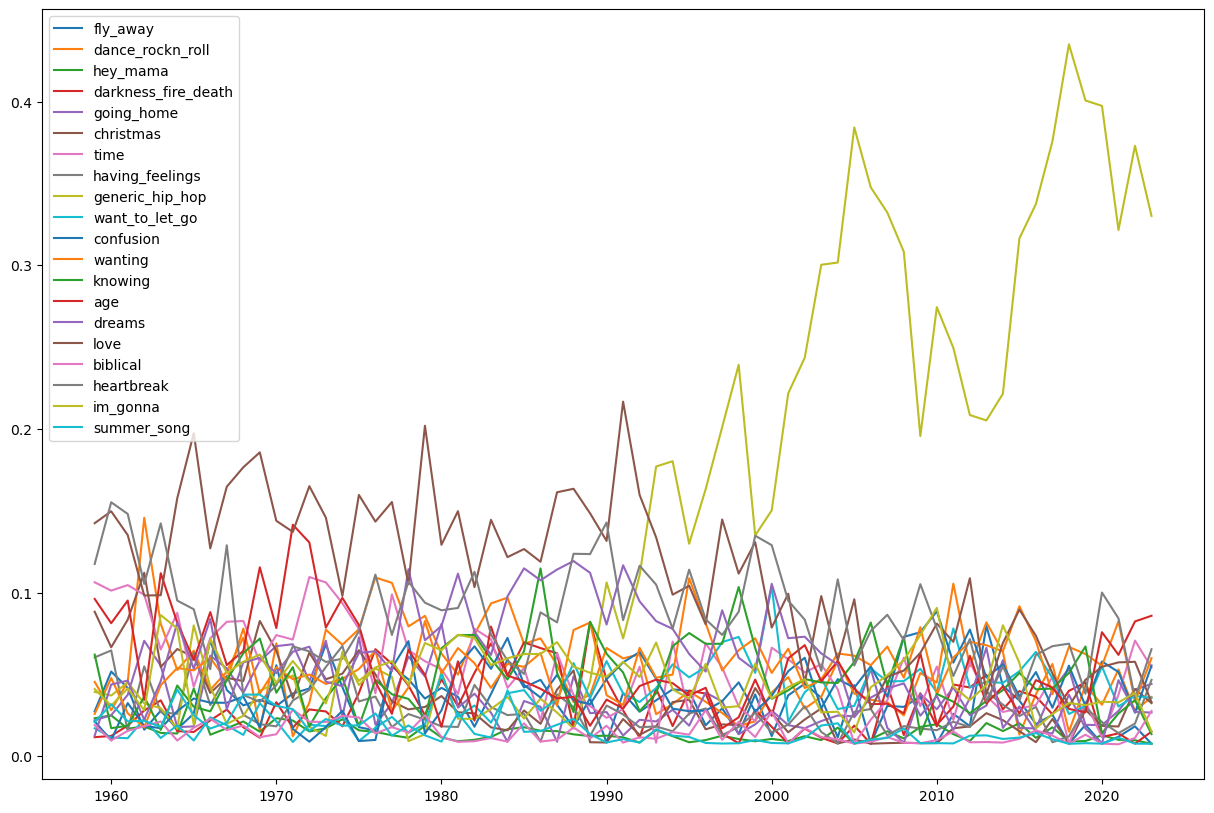

In [236]:
plt.figure(figsize= (15,10))
plt.plot(results_dt.groupby('Year')[topic_list].agg(lambda x: x.sum()/len(x)));
plt.legend(topic_list);

In [263]:
results_dt

,Artist,Year,Song Title,fly_away,dance_rockn_roll,hey_mama,darkness_fire_death,going_home,christmas,time,...,confusion,wanting,knowing,age,dreams,love,biblical,heartbreak,im_gonna,summer_song
0,Johnny Horton,1959.0,the battle of new orleans,0.007859,0.007859,0.007859,0.007859,0.007859,0.007859,0.850678,...,0.007859,0.007859,0.007859,0.007859,0.007859,0.007859,0.007859,0.007859,0.007859,0.007859
1,Bobby Darin,1959.0,mack the knife,0.007807,0.007807,0.152695,0.007807,0.007807,0.007807,0.007807,...,0.007807,0.007807,0.007807,0.706784,0.007807,0.007807,0.007807,0.007807,0.007807,0.007807
2,Lloyd Price,1959.0,personality,0.010093,0.010093,0.010093,0.010093,0.010093,0.010093,0.010093,...,0.010093,0.010093,0.808239,0.010093,0.010093,0.010093,0.010093,0.010093,0.010093,0.010093
3,Frankie Avalon,1959.0,venus,0.007781,0.007781,0.007781,0.007781,0.007781,0.007781,0.007781,...,0.007781,0.007781,0.007781,0.007781,0.007781,0.852164,0.007781,0.007781,0.007781,0.007781
4,Paul Anka,1959.0,lonely boy,0.008204,0.008204,0.008204,0.008204,0.008204,0.008204,0.008204,...,0.008204,0.008204,0.008204,0.008204,0.008204,0.008204,0.008204,0.008204,0.008204,0.008204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5557,Young Nudy featuring 21 Savage,2023.0,peaches eggplants,0.006093,0.006093,0.006093,0.006093,0.006093,0.006093,0.006093,...,0.006093,0.006093,0.006093,0.006093,0.006093,0.006093,0.006093,0.006093,0.006093,0.006093
5558,Morgan Wallen,2023.0,i wrote the book,0.006808,0.006808,0.006808,0.006808,0.006808,0.006808,0.006808,...,0.006808,0.006808,0.006808,0.870650,0.006808,0.006808,0.006808,0.006808,0.006808,0.006808
5559,Latto featuring Cardi B,2023.0,put it on da floor again,0.005765,0.005765,0.005765,0.005765,0.005765,0.005765,0.005765,...,0.005765,0.005765,0.005765,0.005765,0.005765,0.005765,0.005765,0.005765,0.005765,0.005765
5560,Lady Gaga,2023.0,bloody mary,0.009495,0.320968,0.009495,0.009495,0.009495,0.009495,0.009495,...,0.009495,0.009495,0.009495,0.009495,0.009495,0.009495,0.009495,0.009495,0.508113,0.009495


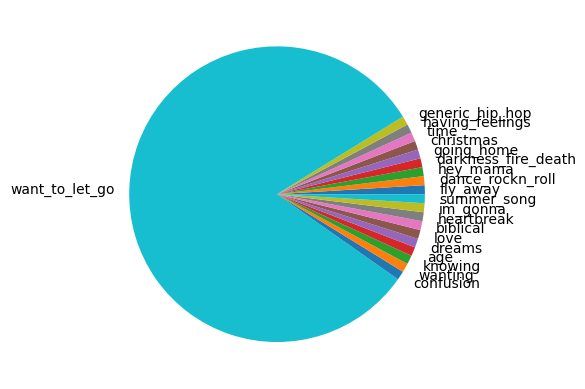

In [277]:
plt.pie(results_dt.loc[results_dt['Song Title'] == 'what do you mean', topic_list].values[0],
        labels= topic_list);

In [272]:
print(data.tail(200).head(100)['Song Title'].tolist())

['positions', 'bad habits', 'heat waves', 'forever after all', 'astronaut in the ocean', 'what you know bout love', 'my exs best friend', 'industry baby', 'therefore i am', 'up', 'fancy like', 'rapstar', 'heartbreak anniversary', 'calling my phone', 'beautiful mistakes', 'on me', 'you broke me first', 'traitor', 'back in blood', 'wockesha', 'you right', 'need to know', 'wants and needs', 'lemonade', 'good days', 'starting over', 'body', 'willow', 'bang', 'better together', 'youre mines still', 'essence', 'chasing after you', 'the good ones', 'leave before you love me', 'glad you exist', 'beggin', 'streets', 'whats next', 'famous friends', 'lil bit', 'thot shit', 'late at night', 'kings queens', 'anyone', 'track star', 'time today', 'no more parties', 'whats your country song', 'one too many', 'arcade', 'if i didnt love you', 'pov', 'just the way', 'take my breath', 'were good', 'hell of a view', 'rockin around the christmas tree', 'put your records on', 'happier than ever', 'single sat

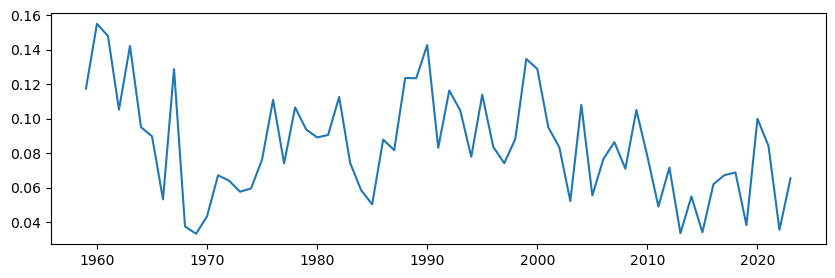

In [256]:
plt.figure(figsize= (10,3))
plt.plot(results_dt.groupby('Year')[["heartbreak"]].agg(lambda x: x.sum()/len(x)));